# WFU Sampling Tutorial

Welcome to this tutorial! Here we will see examples on using the WaveformUncertainty.py package to construct a prior containing waveform uncertainty parameters as well as using the custom waveform generator with bilby to sample over these waveform uncertainties!


Let's quickly look at the math behind what we are doing here:

We need a likelihood function that incorporates waveform differences in it. After some quick math that will be skipped here (see [Likelihood Equation](https://waveformuncertainty.readthedocs.io/en/latest/Likelihood_Equation.html#likelihood-equation) for details), we arrive at the following form of the likelihood equation:

<h3 align='center'>$\mathcal{L}(h|\theta)=\prod_{j}\frac{1}{2\pi{P(f_{j})}}\mathrm{exp}\left(-2\Delta{f}\frac{|h(f_{j})-\mu(f_{j};\theta)(1+\Delta{A})\mathrm{exp}\left[i\Delta\Phi\right]|^{2}}{P(f_{j})}\right)$</h3>

To allow bilby to sample these waveform differences, they must be expressed as a small set of parameters. The most efficient way to do this is to express the waveform uncertainties as spline functions, described by a handful of frequency nodes and corresponding points:

<h3 align='center'>$\Delta{A}\rightarrow\Delta{A}(f;\{f_{n},\alpha_{n}\})\hspace{1cm}\Delta\Phi\rightarrow\Delta\Phi(f;\{f_{n},\beta_{n}\})$</h3>

Now if we define a prior distribution for these alpha and beta parameters (we will fix the frequency nodes for simplicity), bilby can sample them. 

We will use model amplitude uncertainty and model phase uncertainty for our prior distribution. These are defined in the following way:

<h3 align='center'>$\delta{A}_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta{A}_{\mu}(f;\theta_{i})-\overline{\Delta{A}_{\mu}}(f)\right)}{N}}$</h3>

<h3 align='center'>$\delta\Phi_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta\Phi_{\mu}(f;\theta_{i})-\overline{\Delta\Phi_{\mu}}(f)\right)}{N}}$</h3>

These are generated from a large number of model waveform difference draws. We will be pulling these draws from a parameterization file generated earlier. To see how these are made, see [Parameterization Tutorial](https://waveformuncertainty.readthedocs.io/en/latest/notebooks/Parameterization_Tutorial.html#Parameterization-Tutorial)

Assuming a Gaussian distribution of waveform difference around 0, we define the alpha and beta distributions as:

<h3 align='center'>$\alpha_{n}\sim\mathcal{N}(0,\delta{A}(f_{n}))\hspace{1cm}\beta_{n}\sim\mathcal{N}(0,\delta\Phi(f_{n}))$</h3>

Putting all of this back into the likelihood function, we arrive at the final likelihood equation:

<h3 align='center'>$\mathcal{L}(h|\theta,\alpha,\beta)=\prod_{j}\frac{1}{2\pi{P(f_{j})}}\mathrm{exp}\left(-2\Delta{f}\frac{|h(f_{j})-\mu(f_{j};\theta)\left(1+\Delta{A}_{\delta}(f_{j};\{f_{n},\alpha_{n}\})\right)\mathrm{exp}\left[i\Delta\Phi_{\delta}(f_{j};\{f_{n},\beta_{n}\})\right]|^{2}}{P(f_{j})}\right)$</h3>

Now let's look at the code!

This is everything we need to import to run this tutorial. To run surrogate waveform models later, we will need some extra data to get them to work. We do this by changing the `LAL_DATA_PATH` to a directory that contains the needed files. To get these files yourself, see https://git.ligo.org/lscsoft/lalsuite-extra/. If you are running this on https://jupyter.ligo.caltech.edu/, you can run this directly.

In [2]:
import os
os.environ['LAL_DATA_PATH'] = '/home/ryanmatthew.johnson/lalsuite-extra/data/lalsimulation/'
import numpy as np
import bilby
import matplotlib.pyplot as plt
import random
import sys
import scipy
import lal
import pesummary
from pesummary.gw.file.strain import StrainData
from pesummary.io import read

Here we import the WaveformUncertainty package. Make sure you install the package first! See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [3]:
import WaveformUncertainty as wfu

Here we set up a prior with bilby. The values here are based on a GW170817 posterior.

In [4]:
prior = bilby.core.prior.PriorDict()

prior['mass_1'] = bilby.core.prior.Uniform(name='mass_1',latex_label=r'$m_{1}$',minimum=1.37563293,maximum=1.80367393)
prior['mass_2'] = bilby.core.prior.Uniform(name='mass_2',latex_label=r'$m_{2}$',minimum=1.06371259,maximum=1.3758219)
prior['a_1'] = bilby.core.prior.Uniform(name='a_1',latex_label=r'$a_{1}$',minimum=0.0000027020166, maximum=0.04999694)
prior['a_2'] = bilby.core.prior.Uniform(name='a_2',latex_label=r'$a_{2}$',minimum=0.00000212868226, maximum=0.04998414)
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$d_{L}$',minimum=12.27167145, maximum=52.94141976, unit='Mpc')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\Phi_{12}$',minimum=0.00022415, maximum=6.28307139,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\Phi_{JL}$',minimum=0.00038279, maximum=6.28301577,boundary='periodic')
prior['tilt_1'] = bilby.core.prior.Uniform(name='tilt_1',latex_label=r'$\theta_{1}$',minimum=0.00465234, maximum=3.12823758, boundary='periodic')
prior['tilt_2'] = bilby.core.prior.Uniform(name='tilt_2',latex_label=r'$\theta_{2}$',minimum=0.01877421, maximum=3.13573364, boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\Phi$',minimum=0.000089295926, maximum=6.2830611, boundary='periodic')
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.00147326, maximum=3154.41685213)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.02966776, maximum=4598.76616739)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\Psi$',peak=1.56379256)

We load in a premade set of parameterized waveform differences. You can get this file [here](https://github.com/RyanSR71/waveform_uncertainty/tree/main/files).

In [5]:
parameterization = np.load("/home/ryanmatthew.johnson/Waveform_Uncertainty/files/parameterization_nsamples_1000.npy",allow_pickle=True)

Using these sets of waveform differences, we calculate the means and standard deviations, which we define as our uncertainties, $\delta{A}_{\mu}$ and $\delta\Phi_{\mu}$. We pass `linear=True` and `resolution=0.1` to generate a new frequency grid that has linear spacing (0.1 Hz between the points). We need to do this because the frequency grid recovered from the parameterization file has a geometric progression, which will complicate later code.

In [6]:
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty,frequency_grid = wfu.uncertainties_from_parameterization(parameterization,linear=True,resolution=0.1)

We can now generate our waveform uncertainty prior. The following function generates our $\alpha$ and $\beta$ parameters and adds them to the prior we set up earlier. We also get our frequency nodes, $f_{n}$. We define our prior as being a normal distribution around zero with our uncertainties as the standard deviations.

In [7]:
prior,frequency_nodes = wfu.WFU_prior(mean_amplitude_difference=[0]*len(frequency_grid),amplitude_uncertainty=amplitude_uncertainty,
                                      mean_phase_difference=[0]*len(frequency_grid),phase_uncertainty=phase_uncertainty,spacing='geometric',
                                      frequency_grid=frequency_grid,nnodes=6,prior=prior)

We can take a look at the prior to ensure that our parameters were added correctly:

In [8]:
prior

{'mass_1': Uniform(minimum=1.37563293, maximum=1.80367393, name='mass_1', latex_label='$m_{1}$', unit=None, boundary=None),
 'mass_2': Uniform(minimum=1.06371259, maximum=1.3758219, name='mass_2', latex_label='$m_{2}$', unit=None, boundary=None),
 'a_1': Uniform(minimum=2.7020166e-06, maximum=0.04999694, name='a_1', latex_label='$a_{1}$', unit=None, boundary=None),
 'a_2': Uniform(minimum=2.12868226e-06, maximum=0.04998414, name='a_2', latex_label='$a_{2}$', unit=None, boundary=None),
 'luminosity_distance': bilby.gw.prior.UniformSourceFrame(minimum=12.27167145, maximum=52.94141976, cosmology='Planck15', name='luminosity_distance', latex_label='$d_{L}$', unit='Mpc', boundary=None),
 'phi_12': Uniform(minimum=0.00022415, maximum=6.28307139, name='phi_12', latex_label='$\\Phi_{12}$', unit=None, boundary='periodic'),
 'phi_jl': Uniform(minimum=0.00038279, maximum=6.28301577, name='phi_jl', latex_label='$\\Phi_{JL}$', unit=None, boundary='periodic'),
 'tilt_1': Uniform(minimum=0.00465234, 

Let's take a look at the waveform uncertainty prior along with the frequency grids to make this process clearer:

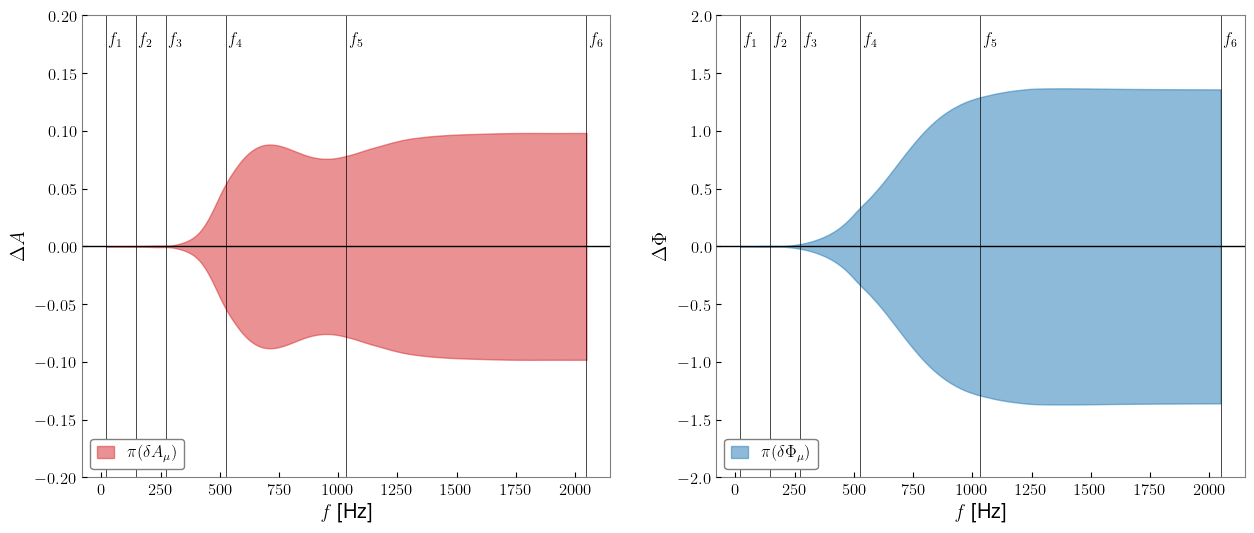

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].fill_between(frequency_grid,-amplitude_uncertainty,amplitude_uncertainty,color='tab:red',alpha=0.5,label=r'$\pi(\delta{A}_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.175))
ax[0].axhline(0,color='k',linewidth=1)
ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.2,0.2)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta{A}$")
ax[0].tick_params(direction='in')

ax[1].fill_between(frequency_grid,-phase_uncertainty,phase_uncertainty,color='tab:blue',alpha=0.5,label=r'$\pi(\delta\Phi_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,1.75))
ax[1].axhline(0,color='k',linewidth=1)
ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-2,2)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()

To use this prior with bilby, we use the `WaveformUncertainty.WaveformGeneratorWFU()` class of waveform generator rather than bilby's. This waveform generator multiplies the output strain by the waveform difference terms we defined earlier. It is identical to bilby's waveform generator other than the three extra arguments: waveform_uncertainty_nodes, dA_sampling, and dphi_sampling. 

In [10]:
hf1 = wfu.WaveformGeneratorWFU(
                    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, catch_waveform_errors=True, 
                                            f_low = 20.0, f_high=2048.0),
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star, 
                    sampling_frequency=4096, 
                    duration=256,
                    # Here are the new arguments
                    waveform_uncertainty_nodes=frequency_nodes,
                    dA_sampling=True,
                    dphi_sampling=True,
                )

16:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


We can then perform a standard PE run with bilby, which will not be shown here.
Because of how long it takes to finish PE runs, we will load in a premade posterior file to look at, `NS_1_wfu_nlive_100_result.json`. You can get this file [here](https://github.com/RyanSR71/waveform_uncertainty/tree/main/files).

In [11]:
result = bilby.read_in_result('/home/ryanmatthew.johnson/Waveform_Uncertainty/output/NS_1_wfu_nlive_100_result.json')

This posterior contains 12 waveform uncertainty parameters and 4 neutron star parameters. We can look at a few of these dimensions to confirm that the waveform uncertainty parameters were properly sampled.

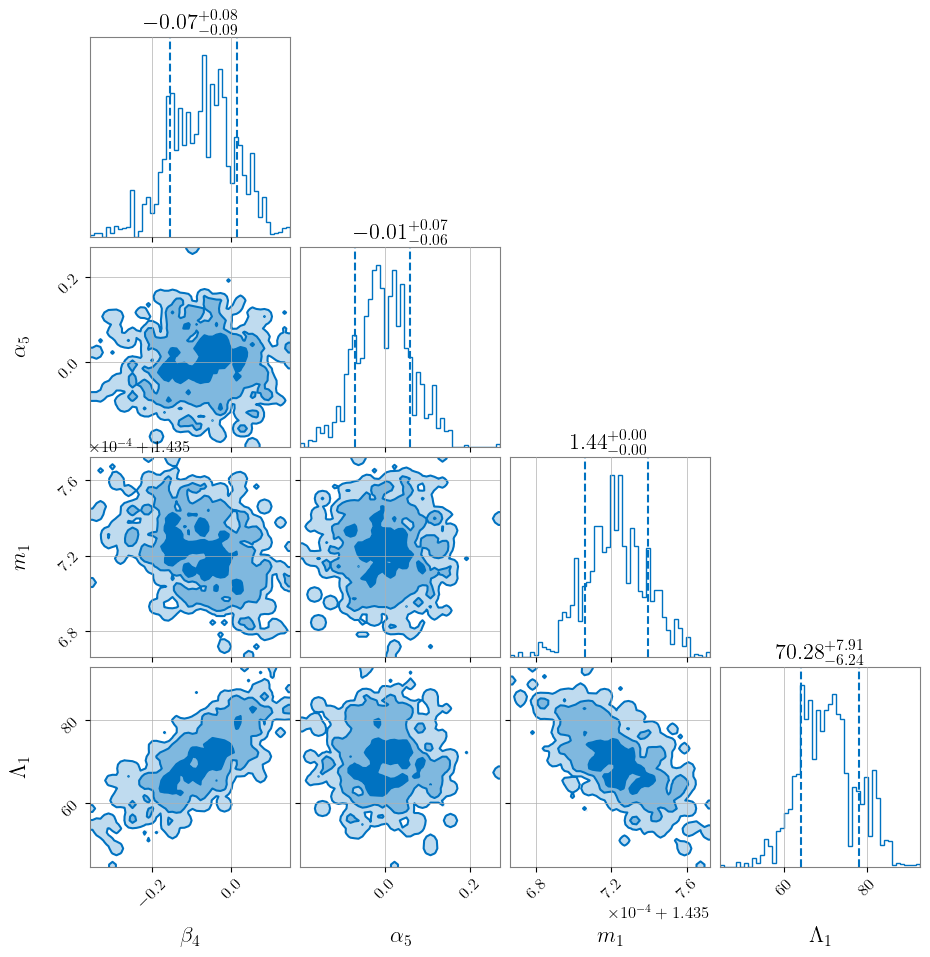

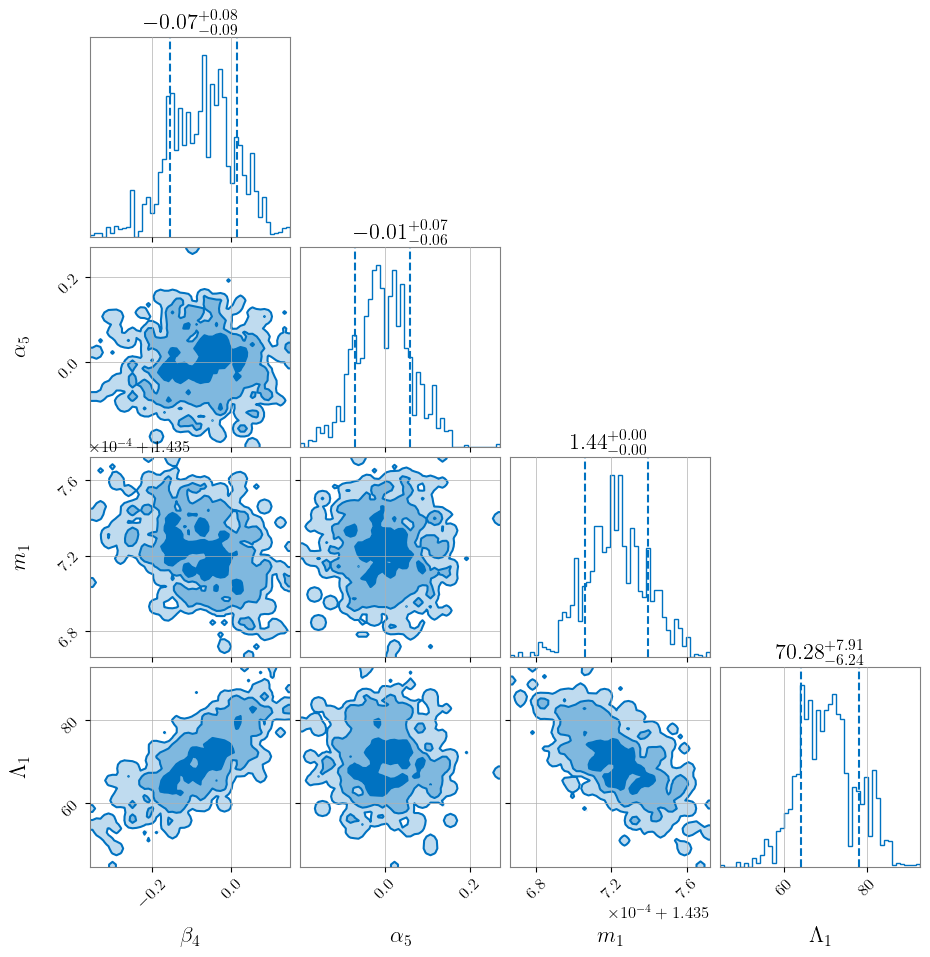

In [12]:
result.plot_corner(['beta_4','alpha_5','mass_1','lambda_1'],save=False)

If we load in this result file again, but as a `samples_dict` object, we can find the maximum likelihood values for our $\alpha$ and $\beta$ parameters. This will tell us what the differences between the waveform model and the data were. We plot these and their standard deviations against the prior distribution.

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


2024-07-11  16:20:58 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2024-07-11  16:20:58 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2024-07-11  16:20:58 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2024-07-11  16:20:58 PESummary WARNING : Could not find f_low in input file and one was not passed from the command line. Using 20.0Hz as default
2024-07-11  16:20:58 PESummary INFO    : Skipping remnant calculations as tidal deformability parameters found in the posterior table.
2024-07-11  16:20:58 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.


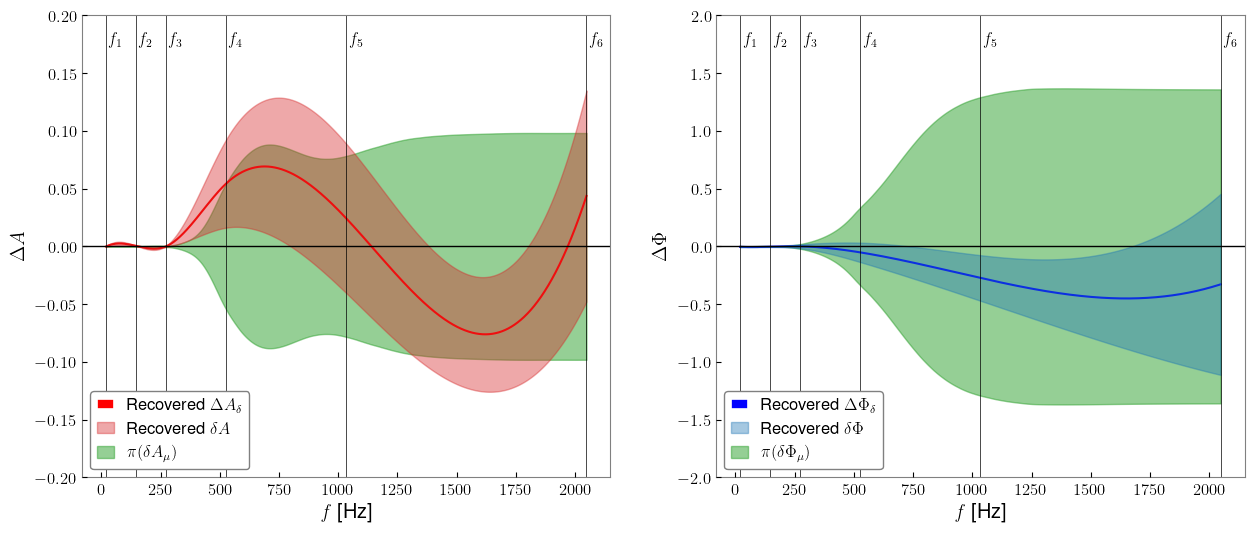

In [13]:
posterior = read('/home/ryanmatthew.johnson/Waveform_Uncertainty/output/NS_1_wfu_nlive_100_result.json',allow_pickle=True).samples_dict

alphas = []
betas = []
dA = []
dphi = []

for i in range(len(frequency_nodes)):
    alphas.append(float(posterior.maxL[f'alpha_{i+1}']))
    betas.append(float(posterior.maxL[f'beta_{i+1}']))
    dA.append(float(np.std(posterior[f'alpha_{i+1}'])))
    dphi.append(float(np.std(posterior[f'beta_{i+1}'])))
    
dA_upper_bound = np.array(alphas)+np.array(dA)
dA_lower_bound = np.array(alphas)-np.array(dA)

dphi_upper_bound = np.array(betas)+np.array(dphi)
dphi_lower_bound = np.array(betas)-np.array(dphi)
    
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,alphas)(frequency_grid),color='red',label=r'Recovered $\Delta{A}_{\delta}$')
ax[0].fill_between(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,dA_upper_bound)(frequency_grid),
                   scipy.interpolate.CubicSpline(frequency_nodes,dA_lower_bound)(frequency_grid),
                   color='tab:red',alpha=0.4,label=r'Recovered $\delta{A}$',zorder=2)

ax[0].fill_between(frequency_grid,-amplitude_uncertainty,amplitude_uncertainty,color='tab:green',alpha=0.5,label=r'$\pi(\delta{A}_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.175))
ax[0].axhline(0,color='k',linewidth=1)
ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.2,0.2)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta{A}$")
ax[0].tick_params(direction='in')


ax[1].plot(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,betas)(frequency_grid),color='blue',label=r'Recovered $\Delta\Phi_{\delta}$')
ax[1].fill_between(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,dphi_upper_bound)(frequency_grid),
                   scipy.interpolate.CubicSpline(frequency_nodes,dphi_lower_bound)(frequency_grid),
                   color='tab:blue',alpha=0.4,label=r'Recovered $\delta\Phi$',zorder=2)

ax[1].fill_between(frequency_grid,-phase_uncertainty,phase_uncertainty,color='tab:green',alpha=0.5,label=r'$\pi(\delta\Phi_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,1.75))
ax[1].axhline(0,color='k',linewidth=1)
ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-2,2)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()

Thank you for going through this tutorial!